In [1]:
"""
Fine-grained classification practice with Flower-17
"""

# Python Packages
import argparse
import os
import time
# 3rd Party Packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# User Packages
from start.preprocessing import ImageToTensorPreprocessor, ResizePreprocessor
from start.loader import ImageDataset
from start.model import MiniVGGNet


In [2]:
# Load Flowers-17 dataset
dataset = ImageDataset(
    preprocessors=[
        ResizePreprocessor(224, 224, aspect_preserving=True),
        ImageToTensorPreprocessor()
    ]
)
(data, labels) = dataset.load(
    dataset_path=r'/home/share/dataset/flowers17',
    verbosity=80
)

print('data shape: {}'.format(data.shape))
print('labels shape: {}'.format(labels.shape))

classes = set(labels)

# Normalize data
data = data.astype(np.float) / 255.0

[INFO] Processing label: dandelion
[INFO] processed 80 dandelion images
[INFO] Processing label: coltsfoot


[INFO] processed 80 coltsfoot images
[INFO] Processing label: lilyvalley
[INFO] processed 80 lilyvalley images
[INFO] Processing label: cowslip


[INFO] processed 80 cowslip images
[INFO] Processing label: iris
[INFO] processed 80 iris images
[INFO] Processing label: snowdrop


[INFO] processed 80 snowdrop images
[INFO] Processing label: sunflower
[INFO] processed 80 sunflower images
[INFO] Processing label: tigerlily


[INFO] processed 80 tigerlily images
[INFO] Processing label: daisy
[INFO] processed 80 daisy images
[INFO] Processing label: pansy


[INFO] processed 80 pansy images
[INFO] Processing label: crocus
[INFO] processed 80 crocus images
[INFO] Processing label: daffodil


[INFO] processed 80 daffodil images
[INFO] Processing label: fritillary
[INFO] processed 80 fritillary images
[INFO] Processing label: buttercup


[INFO] processed 80 buttercup images
[INFO] Processing label: windflower
[INFO] processed 80 windflower images
[INFO] Processing label: files.txt
[INFO] Processing label: tulip


[INFO] processed 80 tulip images
[INFO] Processing label: bluebell
[INFO] processed 80 bluebell images


data shape: (1360, 224, 224, 3)
labels shape: (1360,)


In [3]:
# Setup data splits
# Partition into train and test splits
(trainX, testX, trainY, testY) = train_test_split(
    data, labels,
    test_size=0.3,
    random_state=int(time.time()),
    stratify=list(labels)
)
(valX, testX, valY, testY) = train_test_split(
    testX, testY,
    test_size=0.4,
    random_state=int(time.time()),
    stratify=list(testY)
)

# Binarize output to one hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.fit_transform(valY)
testY = lb.fit_transform(testY)

# Data augmentation
augmenter = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Initialize the optimizer and model
print('[INFO] compiling model...')
opt = SGD(lr=0.05)
properties = {
    'width':    64,
    'height':   64,
    'channels': 3,
    'classes':  len(classes)
}
#model = MiniVGGNet.build(properties)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.4, 
    depth_multiplier=1, 
    include_top=False, 
    weights='imagenet', 
    input_tensor=None, 
    pooling='avg'
))
model.add(Dense(
    units=len(classes),
    activation='softmax',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='glorot_uniform',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None
))
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
#mnv2.summary()
model.summary()

[INFO] compiling model...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.40_224 (Model) (None, 1792)              4363712   
_________________________________________________________________
dense (Dense)                (None, 17)                30481     
Total params: 4,394,193
Trainable params: 4,346,257
Non-trainable params: 47,936
_________________________________________________________________


In [5]:
# Initialize TensorBoard
from tensorflow.keras.callbacks import TensorBoard

BATCH_SIZE = 32

timestamp = time.time()

tb_callback = TensorBoard(
    log_dir='./logs/{}'.format(timestamp), 
    histogram_freq=1, 
    batch_size=BATCH_SIZE, 
    write_graph=True, 
    write_grads=True, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None
)

In [6]:
# Train the network
print('[INFO] training network...')
N_EPOCHS = 75
history = model.fit_generator(
    augmenter.flow(trainX, trainY, 
                   batch_size=BATCH_SIZE),
    validation_data=(valX, valY),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    epochs=N_EPOCHS,
    callbacks=[tb_callback],
    verbose=1
)

[INFO] training network...


[INFO] evaluating network...


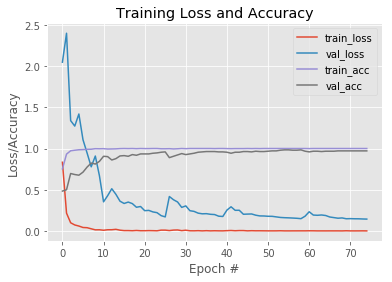

In [8]:
import pycm

# Evaluate the network
print('[INFO] evaluating network...')
predictions = model.predict(testX, batch_size=BATCH_SIZE)

cm = pycm.ConfusionMatrix(
    actual_vector=lb.inverse_transform(testY),
    predict_vector=lb.inverse_transform(predictions)
)
cm.save_html(r'output/confusion_matrix.html')

# Plot the training loss and accuracy
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N_EPOCHS), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, N_EPOCHS), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N_EPOCHS), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, N_EPOCHS), history.history['val_acc'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()